
## Vignette for extracting Long Ids
Reference Guided Isoform Discovery (Bulk)

In [1]:
import os
import re
import glob
import pandas as pd
import numpy as np
import pyranges as pr
import gffutils
import seaborn as sns
import matplotlib.pyplot as plt

In [138]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', 100)

### Matching gene and and transcript ids from Gffcompare outs with Isoquant outs

In [ ]:
!which conda

<h3>looking at the tracking file from gffcompare outs for matching ids </h4>

In [3]:
wd="../test_data/"

In [4]:
colnames=["query_transfrag_id", "query_locus_id", "reference_gene_id","class_code","qJ:gene_id|transcript_id|num_exons|FPKM|TPM|cov|len"]
tracking_df = pd.read_csv(wd+'noRef_isoformSwitchR/gffcmp.tracking', sep='\t',names=colnames, header=None)

In [5]:
print(tracking_df.shape)
tracking_df.head()


(59734, 5)


,query_transfrag_id,query_locus_id,reference_gene_id,class_code,qJ:gene_id|transcript_id|num_exons|FPKM|TPM|cov|len
0,TCONS_00000001,XLOC_000001,-,u,q1:MSTRG.49|MSTRG.49.1|4|0.000000|0.000000|0.0...
1,TCONS_00000002,XLOC_000002,-,u,q1:MSTRG.62|MSTRG.62.1|8|0.000000|0.000000|0.0...
2,TCONS_00000003,XLOC_000002,-,u,q1:MSTRG.62|MSTRG.62.2|8|0.000000|0.000000|0.0...
3,TCONS_00000004,XLOC_000002,-,u,q1:MSTRG.62|MSTRG.62.3|8|0.000000|0.000000|0.0...
4,TCONS_00000005,XLOC_000003,-,u,q1:MSTRG.52|MSTRG.52.1|4|0.000000|0.000000|0.0...


In [7]:
#col0 gene_ids qJ:gene_id
tracking_df["gene_id"]=tracking_df['qJ:gene_id|transcript_id|num_exons|FPKM|TPM|cov|len'].apply(lambda x: x.split('|')[0].split(':')[1])
#col1 transcript_id
tracking_df["transcript_id"]=tracking_df['qJ:gene_id|transcript_id|num_exons|FPKM|TPM|cov|len'].apply(lambda x: x.split('|')[1])
#col2 num_exons
tracking_df["num_exons"]=tracking_df['qJ:gene_id|transcript_id|num_exons|FPKM|TPM|cov|len'].apply(lambda x: x.split('|')[2])
#col3 FPKM
tracking_df['qJ:gene_id|transcript_id|num_exons|FPKM|TPM|cov|len'].apply(lambda x: x.split('|')[3]).unique()
#col4 TPM
tracking_df['qJ:gene_id|transcript_id|num_exons|FPKM|TPM|cov|len'].apply(lambda x: x.split('|')[4]).unique()
#col5 cov
tracking_df['qJ:gene_id|transcript_id|num_exons|FPKM|TPM|cov|len'].apply(lambda x: x.split('|')[5]).unique()
#col6 len
tracking_df["len"]=tracking_df['qJ:gene_id|transcript_id|num_exons|FPKM|TPM|cov|len'].apply(lambda x: x.split('|')[6])

In [8]:
tracking_df=tracking_df[['query_transfrag_id','query_locus_id','reference_gene_id','class_code','gene_id','transcript_id','num_exons','len']]

In [9]:
tracking_df.transcript_id.unique().shape

(59734,)

In [10]:
tracking_df
#check - gffcompare matching at gene vs transcript level

,query_transfrag_id,query_locus_id,reference_gene_id,class_code,gene_id,transcript_id,num_exons,len
0,TCONS_00000001,XLOC_000001,-,u,MSTRG.49,MSTRG.49.1,4,1035
1,TCONS_00000002,XLOC_000002,-,u,MSTRG.62,MSTRG.62.1,8,2579
2,TCONS_00000003,XLOC_000002,-,u,MSTRG.62,MSTRG.62.2,8,2541
3,TCONS_00000004,XLOC_000002,-,u,MSTRG.62,MSTRG.62.3,8,2512
4,TCONS_00000005,XLOC_000003,-,u,MSTRG.52,MSTRG.52.1,4,4605
...,...,...,...,...,...,...,...,...
59729,TCONS_00059730,XLOC_027554,ENSMUSG00000068457.15|ENSMUST00000143958.8,j,MSTRG.29660,MSTRG.29660.1,6,1310
59730,TCONS_00059731,XLOC_027557,ENSMUSG00000069045.12|ENSMUST00000091190.12,=,MSTRG.29662,MSTRG.29662.1,17,4694
59731,TCONS_00059732,XLOC_027557,ENSMUSG00000069045.12|ENSMUST00000091190.12,j,MSTRG.29662,MSTRG.29662.2,17,3851
59732,TCONS_00059733,XLOC_027557,ENSMUSG00000069045.12|ENSMUST00000188182.7,k,MSTRG.29662,MSTRG.29662.3,16,3914


### Looking at the distribution of class codes (similar to SQANTI)

<div class="xtable"><table frame="hsides" rules="groups" content-type="article-table" class="rendered small default_table"><thead><tr><th align="left" valign="top" rowspan="1" colspan="1">Code</th><th align="left" valign="top" rowspan="1" colspan="1">Relationship to reference transcript</th></tr></thead><tbody><tr><td align="left" valign="top" rowspan="1" colspan="1">=</td><td align="left" valign="top" rowspan="1" colspan="1">complete, exact intron chain match</td></tr><tr><td align="left" valign="top" rowspan="1" colspan="1">c</td><td align="left" valign="top" rowspan="1" colspan="1">contained in reference transcript (intron compatible)</td></tr><tr><td align="left" valign="top" rowspan="1" colspan="1">k</td><td align="left" valign="top" rowspan="1" colspan="1">contains reference transcript (reverse containment)</td></tr><tr><td align="left" valign="top" rowspan="1" colspan="1">m</td><td align="left" valign="top" rowspan="1" colspan="1">retained intron(s) compared to reference, full intron chain match
<br>everywhere else</td></tr><tr><td align="left" valign="top" rowspan="1" colspan="1">n</td><td align="left" valign="top" rowspan="1" colspan="1">completely overlaps intron from reference transcript, partial or no intron
<br>chain match everywhere else</td></tr><tr><td align="left" valign="top" rowspan="1" colspan="1">j</td><td align="left" valign="top" rowspan="1" colspan="1">multi-exon with at least one junction match</td></tr><tr><td align="left" valign="top" rowspan="1" colspan="1">e</td><td align="left" valign="top" rowspan="1" colspan="1">single exon that partially covers an intron from reference</td></tr><tr><td align="left" valign="top" rowspan="1" colspan="1">o</td><td align="left" valign="top" rowspan="1" colspan="1">other same strand overlap with reference exons</td></tr><tr><td align="left" valign="top" rowspan="1" colspan="1">s</td><td align="left" valign="top" rowspan="1" colspan="1">intron match on the opposite strand (likely a mapping error)</td></tr><tr><td align="left" valign="top" rowspan="1" colspan="1">x</td><td align="left" valign="top" rowspan="1" colspan="1">exonic overlap on the opposite strand</td></tr><tr><td align="left" valign="top" rowspan="1" colspan="1">i</td><td align="left" valign="top" rowspan="1" colspan="1">fully contained within a reference intron</td></tr><tr><td align="left" valign="top" rowspan="1" colspan="1">y</td><td align="left" valign="top" rowspan="1" colspan="1">contains a reference within its intron(s)</td></tr><tr><td align="left" valign="top" rowspan="1" colspan="1">p</td><td align="left" valign="top" rowspan="1" colspan="1">possible polymerase run-on (close to reference but no overlap)</td></tr><tr><td align="left" valign="top" rowspan="1" colspan="1">r</td><td align="left" valign="top" rowspan="1" colspan="1">repeat (at least 50% bases are soft-masked)</td></tr><tr><td align="left" valign="top" rowspan="1" colspan="1">u</td><td align="left" valign="top" rowspan="1" colspan="1">none of the above (unknown, intergenic)</td></tr></tbody></table></div>

[Text(0.5, 1.0, 'distribution of class codes - Gffcompare \n Ref Free track SAryal data')]

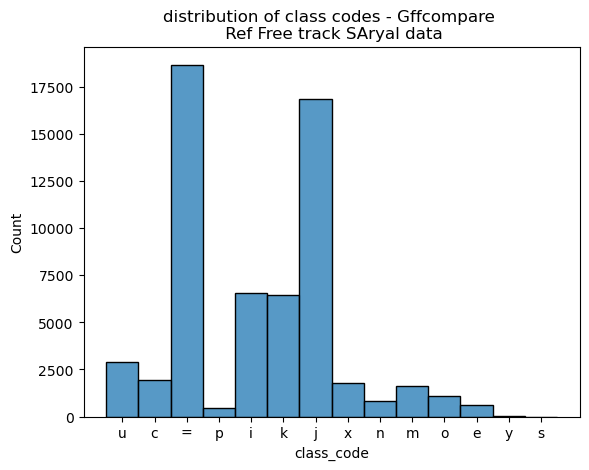

In [11]:
sns.histplot(tracking_df.class_code).set(title='distribution of class codes - Gffcompare \n Ref free track test')

<h5>We have combined count matrix, generated with Isoquant in Quantification mode, quantifying against a reconstrutced gtf - stringtie_merged.noRef.gtf </h5>

In [14]:
isoquant_counts_df = pd.read_csv(wd+'noRef_isoQuant_Quantify/noRef_isoquants_quantify_combined_counts_matrix.tsv', sep='\t')
isoquant_counts_df.head(5)


,isoform_id,bc01,bc02,bc03,bc04,bc05,bc06,bc07,bc08,bc09,bc10
0,MSTRG.1.1,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0
1,MSTRG.10.1,0.0,0.0,1.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0
2,MSTRG.100.1,476.0,596.5,487.5,492.0,431.0,409.0,376.0,479.0,326.0,364.0
3,MSTRG.100.2,33.0,0.0,16.5,0.0,33.0,0.0,0.0,31.0,0.0,0.0
4,MSTRG.1000.1,5.0,2.0,7.0,5.0,6.0,6.0,3.0,8.0,8.0,9.0


In [15]:
isoquant_counts_df.shape

(58891, 11)

In [16]:
tracking_df[['reference_gene_id','class_code','transcript_id']]

,reference_gene_id,class_code,transcript_id
0,-,u,MSTRG.49.1
1,-,u,MSTRG.62.1
2,-,u,MSTRG.62.2
3,-,u,MSTRG.62.3
4,-,u,MSTRG.52.1
...,...,...,...
59729,ENSMUSG00000068457.15|ENSMUST00000143958.8,j,MSTRG.29660.1
59730,ENSMUSG00000069045.12|ENSMUST00000091190.12,=,MSTRG.29662.1
59731,ENSMUSG00000069045.12|ENSMUST00000091190.12,j,MSTRG.29662.2
59732,ENSMUSG00000069045.12|ENSMUST00000188182.7,k,MSTRG.29662.3


In [17]:
print(isoquant_counts_df.shape)
# 59734 
isoquant_counts_df[isoquant_counts_df.isoform_id.str.contains('_')]

(58891, 11)


,isoform_id,bc01,bc02,bc03,bc04,bc05,bc06,bc07,bc08,bc09,bc10
58888,__ambiguous,130040.0,152930.0,127944.0,149126.0,123330.0,110575.0,97357.0,148237.0,113742.0,125599.0
58889,__no_feature,92337.0,115778.0,122255.0,120281.0,129410.0,103025.0,108810.0,107864.0,89838.0,110178.0
58890,__not_aligned,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
isoquant_wRefids=isoquant_counts_df[~isoquant_counts_df.isoform_id.str.contains('_')].merge(tracking_df[['reference_gene_id','class_code','transcript_id']], \
                         how='left', left_on='isoform_id', right_on='transcript_id')

In [19]:
isoquant_wRefids.loc[isoquant_wRefids.isoform_id.isin(['MSTRG.5415.3','MSTRG.12284.4', 
                                                       'MSTRG.6514.2','MSTRG.6514.1',
                                                       'MSTRG.18675.1','MSTRG.19411.3'])]

,isoform_id,bc01,bc02,bc03,bc04,bc05,bc06,bc07,bc08,bc09,bc10,reference_gene_id,class_code,transcript_id
4895,MSTRG.12284.4,6.25,7.10,4.65,9.2,5.80,0.00,0.00,0.00,0.00,0.00,ENSMUSG00000023927.16|ENSMUST00000169480.8,=,MSTRG.12284.4
18925,MSTRG.18675.1,8.67,12.67,7.00,10.0,8.67,8.67,9.50,8.67,6.33,12.83,ENSMUSG00000028397.14|ENSMUST00000030102.12,=,MSTRG.18675.1
20416,MSTRG.19411.3,45.67,62.33,42.33,57.0,45.33,40.67,41.00,62.00,50.33,66.33,ENSMUSG00000028782.15|ENSMUST00000106017.8,j,MSTRG.19411.3
49034,MSTRG.5415.3,53.36,63.29,70.40,59.6,45.40,114.50,88.86,135.02,78.69,121.38,ENSMUSG00000025137.16|ENSMUST00000106188.4,=,MSTRG.5415.3
51427,MSTRG.6514.1,28.00,29.50,22.50,14.5,12.50,16.50,15.50,15.50,16.00,22.00,ENSMUSG00000037679.10|ENSMUST00000222275.2,k,MSTRG.6514.1
51428,MSTRG.6514.2,0.00,0.00,0.00,0.0,0.00,13.50,6.50,0.00,8.00,14.00,ENSMUSG00000037679.10|ENSMUST00000101029.4,j,MSTRG.6514.2


In [20]:
print(isoquant_wRefids.shape)

(58888, 14)


In [21]:
#print(isoquant_wRefids.reference_gene_id.head(10))
#print(isoquant_wRefids.reference_gene_id.apply(lambda x: x.split('|')[-1]).head(10))
#print(isoquant_wRefids.reference_gene_id.apply(lambda x: x.split('|')[0]).head(10))

isoquant_wRefids[['ref_gene_id','ref_transcript_id']]=\
isoquant_wRefids['reference_gene_id'].str.split('|',expand=True)


In [22]:
print(isoquant_wRefids.loc[isoquant_wRefids['reference_gene_id']!='-',].shape)
isoquant_wRefids.loc[isoquant_wRefids['reference_gene_id']!='-',]

(56015, 16)


,isoform_id,bc01,bc02,bc03,bc04,bc05,bc06,bc07,bc08,bc09,bc10,reference_gene_id,class_code,transcript_id,ref_gene_id,ref_transcript_id
1,MSTRG.10.1,0.00,0.00,1.0,0.00,0.0,0.0,2.0,1.0,0.00,0.0,ENSMUSG00000051951.6|ENSMUST00000070533.5,i,MSTRG.10.1,ENSMUSG00000051951.6,ENSMUST00000070533.5
2,MSTRG.100.1,476.00,596.50,487.5,492.00,431.0,409.0,376.0,479.0,326.00,364.0,ENSMUSG00000067879.4|ENSMUST00000088666.4,=,MSTRG.100.1,ENSMUSG00000067879.4,ENSMUST00000088666.4
3,MSTRG.100.2,33.00,0.00,16.5,0.00,33.0,0.0,0.0,31.0,0.00,0.0,ENSMUSG00000067879.4|ENSMUST00000088666.4,j,MSTRG.100.2,ENSMUSG00000067879.4,ENSMUST00000088666.4
4,MSTRG.1000.1,5.00,2.00,7.0,5.00,6.0,6.0,3.0,8.0,8.00,9.0,ENSMUSG00000037035.6|ENSMUST00000038765.6,=,MSTRG.1000.1,ENSMUSG00000037035.6,ENSMUST00000038765.6
5,MSTRG.10000.1,7.00,5.00,5.0,5.00,5.0,12.0,1.0,9.0,8.00,5.0,ENSMUSG00000099083.8|ENSMUST00000096143.2,k,MSTRG.10000.1,ENSMUSG00000099083.8,ENSMUST00000096143.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58883,MSTRG.9998.1,65.33,70.33,74.0,61.67,51.0,65.0,50.0,77.0,46.33,68.0,ENSMUSG00000001285.13|ENSMUST00000113682.9,=,MSTRG.9998.1,ENSMUSG00000001285.13,ENSMUST00000113682.9
58884,MSTRG.9998.2,18.33,22.33,13.0,17.67,14.0,14.0,16.0,23.0,14.33,18.0,ENSMUSG00000001285.13|ENSMUST00000171733.8,k,MSTRG.9998.2,ENSMUSG00000001285.13,ENSMUST00000171733.8
58885,MSTRG.9998.3,1.33,0.00,0.0,0.00,1.0,1.0,0.0,0.0,0.00,0.0,ENSMUSG00000001285.13|ENSMUST00000113682.9,n,MSTRG.9998.3,ENSMUSG00000001285.13,ENSMUST00000113682.9
58886,MSTRG.9999.1,24.00,25.00,26.0,23.50,22.5,24.0,22.5,35.5,26.50,27.0,ENSMUSG00000036678.9|ENSMUST00000041208.9,=,MSTRG.9999.1,ENSMUSG00000036678.9,ENSMUST00000041208.9


In [23]:
isoquant_wRefids=isoquant_wRefids[['transcript_id','ref_gene_id','ref_transcript_id','class_code',\
                  'bc01','bc02','bc03','bc04','bc05',\
                 'bc06','bc07','bc08','bc09','bc10']]

In [24]:
isoquant_wRefids.to_csv(wd+'noRef_isoQuant_Quantify/isoquant_counts_mapped.tsv', sep='\t')

In [25]:
print(isoquant_wRefids.shape)
isoquant_wRefids.head()

(58888, 14)


,transcript_id,ref_gene_id,ref_transcript_id,class_code,bc01,bc02,bc03,bc04,bc05,bc06,bc07,bc08,bc09,bc10
0,MSTRG.1.1,-,None,u,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0
1,MSTRG.10.1,ENSMUSG00000051951.6,ENSMUST00000070533.5,i,0.0,0.0,1.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0
2,MSTRG.100.1,ENSMUSG00000067879.4,ENSMUST00000088666.4,=,476.0,596.5,487.5,492.0,431.0,409.0,376.0,479.0,326.0,364.0
3,MSTRG.100.2,ENSMUSG00000067879.4,ENSMUST00000088666.4,j,33.0,0.0,16.5,0.0,33.0,0.0,0.0,31.0,0.0,0.0
4,MSTRG.1000.1,ENSMUSG00000037035.6,ENSMUST00000038765.6,=,5.0,2.0,7.0,5.0,6.0,6.0,3.0,8.0,8.0,9.0


In [49]:
isoquant_wRefids.transcript_id.split()

,transcript_id,ref_gene_id,ref_transcript_id,class_code,bc01,bc02,bc03,bc04,bc05,bc06,bc07,bc08,bc09,bc10
0,MSTRG.1.1,-,None,u,0.00,0.00,0.0,1.00,1.0,0.0,0.0,0.0,0.00,2.0
1,MSTRG.10.1,ENSMUSG00000051951.6,ENSMUST00000070533.5,i,0.00,0.00,1.0,0.00,0.0,0.0,2.0,1.0,0.00,0.0
2,MSTRG.100.1,ENSMUSG00000067879.4,ENSMUST00000088666.4,=,476.00,596.50,487.5,492.00,431.0,409.0,376.0,479.0,326.00,364.0
3,MSTRG.100.2,ENSMUSG00000067879.4,ENSMUST00000088666.4,j,33.00,0.00,16.5,0.00,33.0,0.0,0.0,31.0,0.00,0.0
4,MSTRG.1000.1,ENSMUSG00000037035.6,ENSMUST00000038765.6,=,5.00,2.00,7.0,5.00,6.0,6.0,3.0,8.0,8.00,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58883,MSTRG.9998.1,ENSMUSG00000001285.13,ENSMUST00000113682.9,=,65.33,70.33,74.0,61.67,51.0,65.0,50.0,77.0,46.33,68.0
58884,MSTRG.9998.2,ENSMUSG00000001285.13,ENSMUST00000171733.8,k,18.33,22.33,13.0,17.67,14.0,14.0,16.0,23.0,14.33,18.0
58885,MSTRG.9998.3,ENSMUSG00000001285.13,ENSMUST00000113682.9,n,1.33,0.00,0.0,0.00,1.0,1.0,0.0,0.0,0.00,0.0
58886,MSTRG.9999.1,ENSMUSG00000036678.9,ENSMUST00000041208.9,=,24.00,25.00,26.0,23.50,22.5,24.0,22.5,35.5,26.50,27.0


In [ ]:
#new_transcript_id= MSTRG.10.1|ENSMUST00000070533.5|i
#new_gene_id= MSTRG.10|ENSMUSG00000051951.6



In [56]:
isoquant_wRefids['strgt_gene_ids']=\
isoquant_wRefids.transcript_id.apply(lambda x: ('.').join(x.split('.')[0:2]))

In [100]:
(isoquant_wRefids[['ref_gene_id','strgt_gene_ids']]\
 .groupby('strgt_gene_ids')['ref_gene_id'].nunique())

strgt_gene_ids
MSTRG.1        1
MSTRG.10       1
MSTRG.100      1
MSTRG.1000     1
MSTRG.10000    1
              ..
MSTRG.9995     1
MSTRG.9996     1
MSTRG.9997     1
MSTRG.9998     1
MSTRG.9999     1
Name: ref_gene_id, Length: 29622, dtype: int64

In [101]:
test=isoquant_wRefids.groupby('strgt_gene_ids').agg({'ref_gene_id':lambda x: len(pd.unique(x))})

In [102]:
test=test.add_suffix('_Count').reset_index()

In [103]:
test

,strgt_gene_ids,ref_gene_id_Count
0,MSTRG.1,1
1,MSTRG.10,1
2,MSTRG.100,1
3,MSTRG.1000,1
4,MSTRG.10000,1
...,...,...
29617,MSTRG.9995,1
29618,MSTRG.9996,1
29619,MSTRG.9997,1
29620,MSTRG.9998,1


In [104]:
test[test.ref_gene_id_Count>1].strgt_gene_ids

60       MSTRG.10051
76       MSTRG.10066
304      MSTRG.10271
322      MSTRG.10288
363      MSTRG.10324
            ...     
29166     MSTRG.9588
29282     MSTRG.9692
29304     MSTRG.9711
29359     MSTRG.9761
29441     MSTRG.9836
Name: strgt_gene_ids, Length: 455, dtype: object

In [114]:
len(isoquant_wRefids.loc\
[isoquant_wRefids.strgt_gene_ids.isin(test[test.ref_gene_id_Count>1].strgt_gene_ids)]\
.strgt_gene_ids.unique())

455

In [116]:
isoquant_wRefids.loc\
[isoquant_wRefids.strgt_gene_ids.isin(test[test.ref_gene_id_Count>1].strgt_gene_ids),\
 ['strgt_gene_ids','transcript_id','ref_gene_id','ref_transcript_id','class_code']]

,strgt_gene_ids,transcript_id,ref_gene_id,ref_transcript_id,class_code
134,MSTRG.10051,MSTRG.10051.1,ENSMUSG00000005982.15,ENSMUST00000186375.8,j
135,MSTRG.10051,MSTRG.10051.10,ENSMUSG00000005982.15,ENSMUST00000186375.8,j
136,MSTRG.10051,MSTRG.10051.11,ENSMUSG00000014232.15,ENSMUST00000040881.14,j
137,MSTRG.10051,MSTRG.10051.12,ENSMUSG00000014232.15,ENSMUST00000040881.14,j
138,MSTRG.10051,MSTRG.10051.13,ENSMUSG00000014232.15,ENSMUST00000040881.14,=
...,...,...,...,...,...
58494,MSTRG.9836,MSTRG.9836.2,ENSMUSG00000045608.8,ENSMUST00000054244.7,j
58495,MSTRG.9836,MSTRG.9836.3,ENSMUSG00000045608.8,ENSMUST00000054244.7,j
58496,MSTRG.9836,MSTRG.9836.4,ENSMUSG00000045608.8,ENSMUST00000054244.7,j
58497,MSTRG.9836,MSTRG.9836.5,ENSMUSG00000115699.3,ENSMUST00000243426.1,j


In [26]:
len(isoquant_wRefids.transcript_id.unique())

58888

In [42]:
len(isoquant_wRefids.ref_transcript_id.unique())

31930

In [46]:
len(isoquant_wRefids.loc[isoquant_wRefids.\
                     duplicated(subset=['ref_transcript_id'])].ref_transcript_id.unique())

10680

In [33]:
isoquant_wRefids.loc[isoquant_wRefids.\
                     duplicated(subset=['ref_transcript_id'])].sort_values(by=['ref_transcript_id'])


,transcript_id,ref_gene_id,ref_transcript_id,class_code,bc01,bc02,bc03,bc04,bc05,bc06,bc07,bc08,bc09,bc10
16864,MSTRG.17696.2,ENSMUSG00000000001.5,ENSMUST00000000001.5,j,0.0,5.5,8.50,6.50,5.5,6.0,6.50,9.0,6.50,7.50
48356,MSTRG.5145.3,ENSMUSG00000000049.12,ENSMUST00000000049.6,j,1.0,3.0,1.00,2.00,2.0,0.0,1.00,1.0,0.00,3.00
48355,MSTRG.5145.2,ENSMUSG00000000049.12,ENSMUST00000000049.6,j,0.0,0.0,2.00,1.00,2.0,1.0,1.00,1.0,0.00,0.00
26078,MSTRG.21976.3,ENSMUSG00000000058.7,ENSMUST00000000058.7,j,0.0,0.0,0.00,0.00,0.0,1.0,0.00,0.0,0.00,0.00
51592,MSTRG.6581.2,ENSMUSG00000000078.8,ENSMUST00000000080.8,m,6.0,7.0,5.33,9.67,7.0,0.0,2.33,8.0,5.33,4.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58818,MSTRG.9966.1,-,None,u,0.0,0.0,0.00,0.00,0.0,0.0,2.00,0.0,0.00,0.00
58828,MSTRG.9971.1,-,None,u,0.0,0.0,0.00,0.00,0.0,1.0,0.00,3.0,0.00,1.00
58842,MSTRG.998.1,-,None,u,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.00,2.00
58846,MSTRG.9981.1,-,None,u,0.0,0.0,0.00,0.00,0.0,0.0,1.00,1.0,2.00,0.00


In [ ]:
isoquant_wRefids['uid']= isoquant_wRefids.


In [41]:
isoquant_wRefids.loc[isoquant_wRefids.\
                     duplicated(subset=['ref_transcript_id'])].groupby(['class_code']).size()


class_code
=     1997
c      511
e      136
i     5381
j    11898
k     1241
m     1225
n      509
o      400
p       51
s        2
u     2872
x      724
y       11
dtype: int64

In [117]:
isoquant_wRefids.loc[isoquant_wRefids.\
                     duplicated(subset=['ref_transcript_id'])].sort_values(by=['ref_transcript_id']) 

# u = novel gene and novel isoform
# c = 

,transcript_id,ref_gene_id,ref_transcript_id,class_code,bc01,bc02,bc03,bc04,bc05,bc06,bc07,bc08,bc09,bc10,strgt_gene_ids
16864,MSTRG.17696.2,ENSMUSG00000000001.5,ENSMUST00000000001.5,j,0.0,5.5,8.50,6.50,5.5,6.0,6.50,9.0,6.50,7.50,MSTRG.17696
48356,MSTRG.5145.3,ENSMUSG00000000049.12,ENSMUST00000000049.6,j,1.0,3.0,1.00,2.00,2.0,0.0,1.00,1.0,0.00,3.00,MSTRG.5145
48355,MSTRG.5145.2,ENSMUSG00000000049.12,ENSMUST00000000049.6,j,0.0,0.0,2.00,1.00,2.0,1.0,1.00,1.0,0.00,0.00,MSTRG.5145
26078,MSTRG.21976.3,ENSMUSG00000000058.7,ENSMUST00000000058.7,j,0.0,0.0,0.00,0.00,0.0,1.0,0.00,0.0,0.00,0.00,MSTRG.21976
51592,MSTRG.6581.2,ENSMUSG00000000078.8,ENSMUST00000000080.8,m,6.0,7.0,5.33,9.67,7.0,0.0,2.33,8.0,5.33,4.33,MSTRG.6581
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58818,MSTRG.9966.1,-,None,u,0.0,0.0,0.00,0.00,0.0,0.0,2.00,0.0,0.00,0.00,MSTRG.9966
58828,MSTRG.9971.1,-,None,u,0.0,0.0,0.00,0.00,0.0,1.0,0.00,3.0,0.00,1.00,MSTRG.9971
58842,MSTRG.998.1,-,None,u,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.00,2.00,MSTRG.998
58846,MSTRG.9981.1,-,None,u,0.0,0.0,0.00,0.00,0.0,0.0,1.00,1.0,2.00,0.00,MSTRG.9981


In [ ]:
#new_transcript_id= MSTRG.10051.1|ENSMUSG00000005982.15|ENSMUST00000186375.8|i
#new_gene_id=MSTRG.10051


In [126]:
isoquant_wRefids=isoquant_wRefids.fillna(value="")

In [128]:
isoquant_wRefids['isoform_id']=isoquant_wRefids[['transcript_id', 'ref_gene_id', 'ref_transcript_id','class_code']]\
.agg('|'.join, axis=1)

In [129]:
isoquant_wRefids

,transcript_id,ref_gene_id,ref_transcript_id,class_code,bc01,bc02,bc03,bc04,bc05,bc06,bc07,bc08,bc09,bc10,strgt_gene_ids,isoform_id
0,MSTRG.1.1,-,,u,0.00,0.00,0.0,1.00,1.0,0.0,0.0,0.0,0.00,2.0,MSTRG.1,MSTRG.1.1|-||u
1,MSTRG.10.1,ENSMUSG00000051951.6,ENSMUST00000070533.5,i,0.00,0.00,1.0,0.00,0.0,0.0,2.0,1.0,0.00,0.0,MSTRG.10,MSTRG.10.1|ENSMUSG00000051951.6|ENSMUST0000007...
2,MSTRG.100.1,ENSMUSG00000067879.4,ENSMUST00000088666.4,=,476.00,596.50,487.5,492.00,431.0,409.0,376.0,479.0,326.00,364.0,MSTRG.100,MSTRG.100.1|ENSMUSG00000067879.4|ENSMUST000000...
3,MSTRG.100.2,ENSMUSG00000067879.4,ENSMUST00000088666.4,j,33.00,0.00,16.5,0.00,33.0,0.0,0.0,31.0,0.00,0.0,MSTRG.100,MSTRG.100.2|ENSMUSG00000067879.4|ENSMUST000000...
4,MSTRG.1000.1,ENSMUSG00000037035.6,ENSMUST00000038765.6,=,5.00,2.00,7.0,5.00,6.0,6.0,3.0,8.0,8.00,9.0,MSTRG.1000,MSTRG.1000.1|ENSMUSG00000037035.6|ENSMUST00000...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58883,MSTRG.9998.1,ENSMUSG00000001285.13,ENSMUST00000113682.9,=,65.33,70.33,74.0,61.67,51.0,65.0,50.0,77.0,46.33,68.0,MSTRG.9998,MSTRG.9998.1|ENSMUSG00000001285.13|ENSMUST0000...
58884,MSTRG.9998.2,ENSMUSG00000001285.13,ENSMUST00000171733.8,k,18.33,22.33,13.0,17.67,14.0,14.0,16.0,23.0,14.33,18.0,MSTRG.9998,MSTRG.9998.2|ENSMUSG00000001285.13|ENSMUST0000...
58885,MSTRG.9998.3,ENSMUSG00000001285.13,ENSMUST00000113682.9,n,1.33,0.00,0.0,0.00,1.0,1.0,0.0,0.0,0.00,0.0,MSTRG.9998,MSTRG.9998.3|ENSMUSG00000001285.13|ENSMUST0000...
58886,MSTRG.9999.1,ENSMUSG00000036678.9,ENSMUST00000041208.9,=,24.00,25.00,26.0,23.50,22.5,24.0,22.5,35.5,26.50,27.0,MSTRG.9999,MSTRG.9999.1|ENSMUSG00000036678.9|ENSMUST00000...


In [130]:
isoquant_counts_combined_wRefids=isoquant_wRefids[['isoform_id',\
                  'bc01','bc02','bc03','bc04','bc05',\
                 'bc06','bc07','bc08','bc09','bc10']]

In [139]:
isoquant_counts_combined_wRefids.head(5)

,isoform_id,bc01,bc02,bc03,bc04,bc05,bc06,bc07,bc08,bc09,bc10
0,MSTRG.1.1|-||u,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0
1,MSTRG.10.1|ENSMUSG00000051951.6|ENSMUST00000070533.5|i,0.0,0.0,1.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0
2,MSTRG.100.1|ENSMUSG00000067879.4|ENSMUST00000088666.4|=,476.0,596.5,487.5,492.0,431.0,409.0,376.0,479.0,326.0,364.0
3,MSTRG.100.2|ENSMUSG00000067879.4|ENSMUST00000088666.4|j,33.0,0.0,16.5,0.0,33.0,0.0,0.0,31.0,0.0,0.0
4,MSTRG.1000.1|ENSMUSG00000037035.6|ENSMUST00000038765.6|=,5.0,2.0,7.0,5.0,6.0,6.0,3.0,8.0,8.0,9.0


In [140]:
isoquant_counts_combined_wRefids.to_csv(\
    '/Users/akhorgad/Desktop/MDL/SAryal/noRef_isoformSwitchR/isoquant_counts_combined_wRefids.tsv', \
     sep='\t') 


In [ ]:
MSTRG.12284.4 ENSMUSG00000023927.16|ENSMUST00000169480.8 (Transcript: ENSMUST00000169480.8 Satb1-213)
MSTRG.5415.3 ENSMUSG00000025137.16|ENSMUST00000106188.4 (ENSMUSG00000025137-Pcyt2)

MSTRG.19411.3 ENSMUSG00000028782.15|ENSMUST00000106017.8 (Transcript:Adgrb2-205)

MSTRG.6514.1 ENSMUSG00000037679.10|ENSMUST00000222275.2 (Transcript Inf2-203) k
MSTRG.6514.2 ENSMUSG00000037679.10|ENSMUST00000101029.4 (Transcript Inf2-201) j

MSTRG.18675.1 ENSMUSG00000028397.14|ENSMUST00000030102.12 (geneid | transcript id, Kdm4c-201)

In [ ]:
isoquant_wRefids.isoform_id
isoquant_wRefids.loc[isoquant_wRefids.isoform_id.isin(['MSTRG.1.1','MSTRG.10.1','MSTRG.100.1','MSTRG.29666'])]

<h3>Updating the gtf with Ref Ensemble ids</h3>

In [141]:
gtf_f=wd+'noRef_isoformSwitchR/stringtie_merged.noRef.gtf'
# as PyRanges-object
gr_noR = pr.read_gtf(gtf_f)

In [ ]:
'''
try:
    db = gffutils.create_db(gtf_f, dbfn='noRef.db')
except:
    pass
db = gffutils.FeatureDB('noRef.db', keep_order=True)
with open('noRef.txt', 'w') as fout:
    for line in db.all_features():
        line = str(line)
        
        line = line.split(";") #make your parsing changes here
        fout.write(str(line) + '\n')
db = gffutils.FeatureDB('noRef.db', keep_order=True)
'''

In [ ]:
'''
for line in db.all_features():
    print(line)
'''

    
#gene_id "MSTRG.1"; transcript_id "MSTRG.1.1";  ""  
#disregard the gene_id part here, only use MSTRG.1.1 and look up gene_id

In [ ]:
#tmap_df = pd.read_csv(wd+'noRef_isoformSwitchR/noRef.txt', sep='\t', header=None)

In [142]:
gr_noR_df=gr_noR.df

In [143]:
print(gr_noR_df.shape)
gr_noR_df.head()
# 59734 number of unique transcripts from gffcompare tracking file

(474332, 11)


,Chromosome,Source,Feature,Start,End,Score,Strand,Frame,gene_id,transcript_id,exon_number
0,GL456233.2,StringTie,transcript,251317,422545,1000,+,.,MSTRG.49,MSTRG.49.1,NaN
1,GL456233.2,StringTie,exon,251317,251452,1000,+,.,MSTRG.49,MSTRG.49.1,1
2,GL456233.2,StringTie,exon,354605,354787,1000,+,.,MSTRG.49,MSTRG.49.1,2
3,GL456233.2,StringTie,exon,394862,395039,1000,+,.,MSTRG.49,MSTRG.49.1,3
4,GL456233.2,StringTie,exon,422004,422545,1000,+,.,MSTRG.49,MSTRG.49.1,4


In [144]:
gr_noR_df[gr_noR_df.Feature=='transcript'].transcript_id.unique().shape
# 59734 transcripts in gtf 

(59734,)

In [109]:
#MSTRG.10051.10
gr_noR_df.loc[gr_noR_df['gene_id']=='MSTRG.10051',].transcript_id.unique()

array(['MSTRG.10051.1', 'MSTRG.10051.2', 'MSTRG.10051.3', 'MSTRG.10051.4',
       'MSTRG.10051.5', 'MSTRG.10051.6', 'MSTRG.10051.7', 'MSTRG.10051.8',
       'MSTRG.10051.9', 'MSTRG.10051.10', 'MSTRG.10051.11',
       'MSTRG.10051.12', 'MSTRG.10051.13', 'MSTRG.10051.14',
       'MSTRG.10051.15', 'MSTRG.10051.16', 'MSTRG.10051.17',
       'MSTRG.10051.18'], dtype=object)

In [233]:
print(isoquant_wRefids.shape)
isoquant_wRefids.head()

(58888, 16)


,transcript_id,ref_gene_id,ref_transcript_id,class_code,bc01,bc02,bc03,bc04,bc05,bc06,bc07,bc08,bc09,bc10,strgt_gene_ids,isoform_id
0,MSTRG.1.1,-,,u,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,MSTRG.1,MSTRG.1.1|-||u
1,MSTRG.10.1,ENSMUSG00000051951.6,ENSMUST00000070533.5,i,0.0,0.0,1.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,MSTRG.10,MSTRG.10.1|ENSMUSG00000051951.6|ENSMUST00000070533.5|i
2,MSTRG.100.1,ENSMUSG00000067879.4,ENSMUST00000088666.4,=,476.0,596.5,487.5,492.0,431.0,409.0,376.0,479.0,326.0,364.0,MSTRG.100,MSTRG.100.1|ENSMUSG00000067879.4|ENSMUST00000088666.4|=
3,MSTRG.100.2,ENSMUSG00000067879.4,ENSMUST00000088666.4,j,33.0,0.0,16.5,0.0,33.0,0.0,0.0,31.0,0.0,0.0,MSTRG.100,MSTRG.100.2|ENSMUSG00000067879.4|ENSMUST00000088666.4|j
4,MSTRG.1000.1,ENSMUSG00000037035.6,ENSMUST00000038765.6,=,5.0,2.0,7.0,5.0,6.0,6.0,3.0,8.0,8.0,9.0,MSTRG.1000,MSTRG.1000.1|ENSMUSG00000037035.6|ENSMUST00000038765.6|=


In [252]:
#MSTRG.12246.3_ENSMUSG00000023266.12_ENSMUST00000113296.8

isoquant_wRefids.loc[isoquant_wRefids.isoform_id.str.contains\
                 ('MSTRG.12246.3|MSTRG.12284.1|MSTRG.12284.2|MSTRG.16165.1|MSTRG.4988.1'),['transcript_id','isoform_id']]


,transcript_id,isoform_id
4804,MSTRG.12246.3,MSTRG.12246.3|ENSMUSG00000023266.12|ENSMUST00000113296.8|=
4892,MSTRG.12284.1,MSTRG.12284.1|ENSMUSG00000023927.16|ENSMUST00000152830.9|=
4893,MSTRG.12284.2,MSTRG.12284.2|ENSMUSG00000023927.16|ENSMUST00000144331.8|=
13480,MSTRG.16165.1,MSTRG.16165.1|ENSMUSG00000073236.6|ENSMUST00000139636.3|=
48040,MSTRG.4988.1,MSTRG.4988.1|ENSMUSG00000020926.17|ENSMUST00000103081.10|=


In [40]:
# number of unique transcripts in the reconstructed gtf : 59734
# number of unique transcripts in the quantification matrix based on the gtf : 58888
59734 - 58888

846

In [163]:
gr_wRefids=gr_noR_df.merge(\
    isoquant_wRefids[['transcript_id','strgt_gene_ids','ref_gene_id','ref_transcript_id','isoform_id','class_code']],\
    how='left', on='transcript_id')


In [197]:
print(gr_wRefids.shape)
gr_wRefids.head(5)
# 7618 transcript ids in the gtf do not exist in isoquant results.

(474332, 16)


,Chromosome,Source,Feature,Start,End,Score,Strand,Frame,gene_id,mstrg_transcript,exon_number,mstrg_gene,ensmb_gene,ensmb_transcript,isoform_id,class_code
0,GL456233.2,StringTie,transcript,251317,422545,1000,+,.,MSTRG.49,MSTRG.49.1,NaN,MSTRG.49,-,,MSTRG.49.1|-||u,u
1,GL456233.2,StringTie,exon,251317,251452,1000,+,.,MSTRG.49,MSTRG.49.1,1,MSTRG.49,-,,MSTRG.49.1|-||u,u
2,GL456233.2,StringTie,exon,354605,354787,1000,+,.,MSTRG.49,MSTRG.49.1,2,MSTRG.49,-,,MSTRG.49.1|-||u,u
3,GL456233.2,StringTie,exon,394862,395039,1000,+,.,MSTRG.49,MSTRG.49.1,3,MSTRG.49,-,,MSTRG.49.1|-||u,u
4,GL456233.2,StringTie,exon,422004,422545,1000,+,.,MSTRG.49,MSTRG.49.1,4,MSTRG.49,-,,MSTRG.49.1|-||u,u


In [165]:
gr_wRefids[['ref_transcript_id','class_code']].groupby(['class_code']).size()

class_code
=    178772
c     10856
e      1180
i     13420
j    157268
k     70125
m     13966
n      5578
o      2821
p       864
s        14
u      6995
x      4718
y       137
dtype: int64

In [166]:
gr_wRefids[gr_wRefids['ref_transcript_id']==""].groupby(['class_code']).size()

class_code
u    6995
dtype: int64

In [178]:
gr_wRefids=gr_wRefids.rename(columns={'transcript_id':'mstrg_transcript'})

In [167]:
gr_wRefids=gr_wRefids.rename(columns={'strgt_gene_ids':'mstrg_gene',
                  'isoform_id':'transcript_id',                    
                  'ref_gene_id': 'ensmb_gene',
                  'ref_transcript_id':'ensmb_transcript'})


In [204]:
len(gr_wRefids[gr_wRefids['isoform_id'].isnull()])

7618

In [207]:
gr_wRefids['isoform_id']=gr_wRefids['isoform_id'].fillna("")

In [210]:
len(gr_wRefids[gr_wRefids['isoform_id'].isnull()])

0

In [211]:
len(gr_wRefids[gr_wRefids['isoform_id']==""])

7618

In [209]:
gr_wRefids.apply(lambda x : x.mstrg_transcript if x.isoform_id=="" \
                            else x.isoform_id , \
                            axis=1)

0            MSTRG.49
1            MSTRG.49
2            MSTRG.49
3            MSTRG.49
4            MSTRG.49
             ...     
474327    MSTRG.29666
474328    MSTRG.29666
474329    MSTRG.29666
474330    MSTRG.29666
474331    MSTRG.29666
Length: 474332, dtype: object

In [219]:
gr_wRefids["transcript_id"]=gr_wRefids.apply(lambda x : x.mstrg_transcript if x.isoform_id=="" \
                            else  x.isoform_id, \
                            axis=1)

In [220]:
len(gr_wRefids[gr_wRefids['transcript_id']==""])

0

In [221]:
len(gr_wRefids.loc[(gr_wRefids['class_code']=='u') & (gr_wRefids['Feature']=='transcript'),])

2873

In [223]:
gr_wRefids=gr_wRefids.drop(['mstrg_gene','mstrg_transcript','ensmb_gene',\
                            'ensmb_transcript','isoform_id','class_code'], axis=1)


In [224]:
gr_wRefids

,Chromosome,Source,Feature,Start,End,Score,Strand,Frame,gene_id,exon_number,transcript_id
0,GL456233.2,StringTie,transcript,251317,422545,1000,+,.,MSTRG.49,NaN,MSTRG.49.1|-||u
1,GL456233.2,StringTie,exon,251317,251452,1000,+,.,MSTRG.49,1,MSTRG.49.1|-||u
2,GL456233.2,StringTie,exon,354605,354787,1000,+,.,MSTRG.49,2,MSTRG.49.1|-||u
3,GL456233.2,StringTie,exon,394862,395039,1000,+,.,MSTRG.49,3,MSTRG.49.1|-||u
4,GL456233.2,StringTie,exon,422004,422545,1000,+,.,MSTRG.49,4,MSTRG.49.1|-||u
...,...,...,...,...,...,...,...,...,...,...,...
474327,chrY,StringTie,transcript,90763694,90772729,1000,-,.,MSTRG.29666,NaN,MSTRG.29666.1|ENSMUSG00000095366.3|ENSMUST00000177893.2|k
474328,chrY,StringTie,exon,90763694,90764192,1000,-,.,MSTRG.29666,1,MSTRG.29666.1|ENSMUSG00000095366.3|ENSMUST00000177893.2|k
474329,chrY,StringTie,exon,90765689,90766299,1000,-,.,MSTRG.29666,2,MSTRG.29666.1|ENSMUSG00000095366.3|ENSMUST00000177893.2|k
474330,chrY,StringTie,exon,90767289,90767449,1000,-,.,MSTRG.29666,3,MSTRG.29666.1|ENSMUSG00000095366.3|ENSMUST00000177893.2|k


# Writing gtf - strtingtie ids 

In [225]:
 gr_wRefids_pr= pr.PyRanges(gr_wRefids)

In [227]:
gr_wRefids_pr.head()


,Chromosome,Source,Feature,Start,End,Score,Strand,Frame,gene_id,exon_number,transcript_id
0,GL456233.2,StringTie,transcript,251317,422545,1000,+,.,MSTRG.49,NaN,MSTRG.49.1|-||u
1,GL456233.2,StringTie,exon,251317,251452,1000,+,.,MSTRG.49,1,MSTRG.49.1|-||u
2,GL456233.2,StringTie,exon,354605,354787,1000,+,.,MSTRG.49,2,MSTRG.49.1|-||u
3,GL456233.2,StringTie,exon,394862,395039,1000,+,.,MSTRG.49,3,MSTRG.49.1|-||u
4,GL456233.2,StringTie,exon,422004,422545,1000,+,.,MSTRG.49,4,MSTRG.49.1|-||u
5,GL456233.2,StringTie,transcript,196593,206895,1000,-,.,MSTRG.52,NaN,MSTRG.52.1|-||u
6,GL456233.2,StringTie,exon,196593,200564,1000,-,.,MSTRG.52,1,MSTRG.52.1|-||u
7,GL456233.2,StringTie,exon,201259,201382,1000,-,.,MSTRG.52,2,MSTRG.52.1|-||u


In [231]:
gr_wRefids_pr.to_gtf(\
  "localdir/stringtie_merged.wRefIds.gtf")


In [232]:
! cat /Users/akhorgad/Desktop/MDL/SAryal/noRef_isoformSwitchR/stringtie_merged.noRef.wRefIds.gtf | head -5

GL456233.2	StringTie	transcript	251318	422545	1000	+	.	gene_id "MSTRG.49"; transcript_id "MSTRG.49.1|-||u";
GL456233.2	StringTie	exon	251318	251452	1000	+	.	gene_id "MSTRG.49"; exon_number "1"; transcript_id "MSTRG.49.1|-||u";
GL456233.2	StringTie	exon	354606	354787	1000	+	.	gene_id "MSTRG.49"; exon_number "2"; transcript_id "MSTRG.49.1|-||u";
GL456233.2	StringTie	exon	394863	395039	1000	+	.	gene_id "MSTRG.49"; exon_number "3"; transcript_id "MSTRG.49.1|-||u";
GL456233.2	StringTie	exon	422005	422545	1000	+	.	gene_id "MSTRG.49"; exon_number "4"; transcript_id "MSTRG.49.1|-||u";
cat: stdout: Broken pipe


In [ ]:
stringtieMergeId^refTranscriptId

In [230]:
! cat data/isoquant_counts_combined_wRefids.tsv | head -5

	isoform_id	bc01	bc02	bc03	bc04	bc05	bc06	bc07	bc08	bc09	bc10
0	MSTRG.1.1|-||u	0.0	0.0	0.0	1.0	1.0	0.0	0.0	0.0	0.0	2.0
1	MSTRG.10.1|ENSMUSG00000051951.6|ENSMUST00000070533.5|i	0.0	0.0	1.0	0.0	0.0	0.0	2.0	1.0	0.0	0.0
2	MSTRG.100.1|ENSMUSG00000067879.4|ENSMUST00000088666.4|=	476.0	596.5	487.5	492.0	431.0	409.0	376.0	479.0	326.0	364.0
3	MSTRG.100.2|ENSMUSG00000067879.4|ENSMUST00000088666.4|j	33.0	0.0	16.5	0.0	33.0	0.0	0.0	31.0	0.0	0.0
cat: stdout: Broken pipe
